# Chapter 4: Granger Causality Test

In this chapter, we introduce the notion of causality and describe a test for linear models. The VAR model discussed in the previous chapter will be applied here.

**References**

The contents of this notebook are compiled from the following references:

* [Granger, C. (1969). Investigating Causal Relations by Econometric Models and Cross-spectral Methods. Econometrica, 37(3), 424-438.](https://www.jstor.org/stable/1912791)
* [Toda, Hiro Y. & Yamamoto, Taku (1995). Statistical inference in vector autoregressions with possibly integrated processes. Journal of Econometrics, 66(1-2), 225-250.](https://ideas.repec.org/a/eee/econom/v66y1995i1-2p225-250.html)
* [Hood, M., Kidd, Q., & Morris, I. (2008). Two Sides of the Same Coin? Employing Granger Causality Tests in a Time Series Cross-Section Framework. Political Analysis, 16(3), 324-344.](https://www.jstor.org/stable/25791939)
* [Testing for Granger Causality Using Python](https://rishi-a.github.io/2020/05/25/granger-causality.html)

Prepared by: Carlo Vincienzo G. Dajac

## Notations

If $A_t$ is a stationary stochastic process, let $\overline A_t$ represent the set of *past* values ${A_{t-j}, \; j=1,2,\ldots,\infty}$ and $\overline{\overline A}_t$ represent the set of *past and present* values ${A_{t-j}, \; j=0,1,\ldots,\infty}$. Further, let $\overline A(k)$ represent the set ${A_{t-j}, \; j=k,k+1,\ldots,\infty}$.

Denote the optimum, unbiased, least-squares predictor of $A_t$ using the set of values $B_t$ by $P_t (A|B)$. Thus, for instance, $P_t (X|\overline X)$ will be the optimum predictor of $X_t$ using only past $X_t$. The predictive error series will be denoted by $\varepsilon_t(A|B) = A_t - P_t(A|B)$. Let $\sigma^2 (A|B)$ be the variance of $\varepsilon_t(A|B)$.

Let $U_t$ be all the information in the universe accumulated since time $t-1$ and let $U_t - Y_t$ denote all this information *apart* from the specified series $Y_t$.

## Definitions


### Causality

If $\sigma^2 (X|U) < \sigma^2 (X| \overline{U-Y})$, we say that $Y$ is causing $X$, denoted by $Y_t \implies X_t$. We say that $Y_t$ is causing $X_t$ if we are able to predict $X_t$ using all available information than if the information apart from $Y_t$ had been used.

### Feedback
If $\sigma^2 (X|\overline U) < \sigma^2 (X| \overline{U-Y})$ and $\sigma^2 (Y|\overline U) < \sigma^2 (Y| \overline{U-X})$, we say that feedback is occurring, which is denoted by $Y_t \iff X_t$, i.e., feedback is said to occur when $X_t$ is causing $Y_t$ and also $Y_t$ is causing $X_t$.

### Instantaneous Causality
If $\sigma^2 (X|\overline U, \overline{\overline Y}) < \sigma^2 (X| \overline U)$, we say that instantaneous causality $Y_t \implies X_t$ is occurring. In other words, the current value of $X_t$ is better "predicted" if the present value of $Y_t$ is included in the "prediction" than if it is not.

### Causality Lag
If $Y_t \implies X_t$, we define the (integer) causality lag $m$ to be the least value of $k$ such that $\sigma^2 (X|U-Y(k)) < \sigma^2 (X|U-Y(k+1))$. Thus, knowing the values $Y_{t-j}, \; j=0,1,\ldots,m-1$ will be of no help in improving the prediction of $X_t$

## Assumptions

* Series is stationary.
* Linear model is already optimized.

## Testing for Granger Causality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pandas.plotting import lag_plot
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson

We will use the Ipo dataset in this notebook.

In [2]:
data = pd.read_csv('../data/Ipo_dataset.csv', index_col='Time');
data = data.dropna()
data

,Rain,ONI,NIA,Dam
Time,,,,
0,0.00,-0.7,38.225693,100.70
1,0.00,-0.7,57.996530,100.63
2,0.00,-0.7,49.119213,100.56
3,0.00,-0.7,47.034720,100.55
4,0.00,-0.7,42.223380,100.48
...,...,...,...,...
7111,1.80,-0.2,5.040000,100.86
7112,1.60,-0.2,4.500000,101.01
7113,21.60,-0.2,6.730000,101.08


As an example, we will only use the NIA and Dam time series.

In [3]:
data = data.drop(['Rain', 'ONI'], axis=1)
data

,NIA,Dam
Time,,
0,38.225693,100.70
1,57.996530,100.63
2,49.119213,100.56
3,47.034720,100.55
4,42.223380,100.48
...,...,...
7111,5.040000,100.86
7112,4.500000,101.01
7113,6.730000,101.08


**Step 1**: Test each time series for stationarity. Ideally, this should involve using a test (such as the ADF test) where the null hypothesis is non-stationarity, as well as a test (such as the KPSS test) where the null is stationarity. This is a good cross-check.

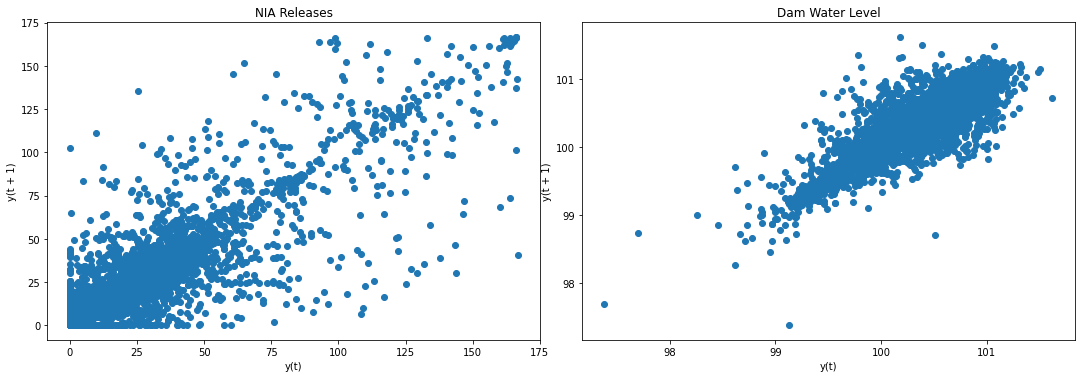

In [4]:
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

# lag_plot(data['Rain'], ax=ax4)
# ax4.set_title('Rainfall');

lag_plot(data['NIA'], ax=ax4)
ax4.set_title('NIA Releases');

lag_plot(data['Dam'], ax=ax5)
ax5.set_title('Dam Water Level');

plt.show()

**Result**: Both data are not stationary. We can make them stationary through differencing.

In [5]:
# differencing for stationarity check
rawData = data.copy(deep=True)

# data['Rain'] = data['Rain'] - data['Rain'].shift(1)
data['NIA'] = data['NIA'] - data['NIA'].shift(1)
data['Dam'] = data['Dam'] - data['Dam'].shift(1)
data = data.dropna()

In [6]:
# split data into train and test sets for VAR later on
end = round(len(data)*.8)
train = data[:end]
test = data[end:]

In [7]:
# ADF Null Hypothesis: there is a unit root, meaning series is non-stationary

X1 = np.array(data['Dam'])
X1 = X1[~np.isnan(X1)]

result = adfuller(X1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
# X2 = np.array(data['Rain'])
X2 = np.array(data['NIA'])
X2 = X2[~np.isnan(X2)]

result = adfuller(X2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -21.591918
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistic: -21.283687
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [8]:
# KPSS Null Hypothesis: there is no unit root, meaning series is stationary

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(X1)
kpss_test(X2)

KPSS Statistic: 0.009242367643647212
p-value: 0.1
num lags: 35
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.005036520393528595
p-value: 0.1
num lags: 35
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/Users/eloiventura/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/eloiventura/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/Users/eloiventura/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


**Results**: ADF Null Hypothesis is rejected. Thus, data is stationary. KPSS Null Hypothesis could not be rejected. Thus, data is stationary.

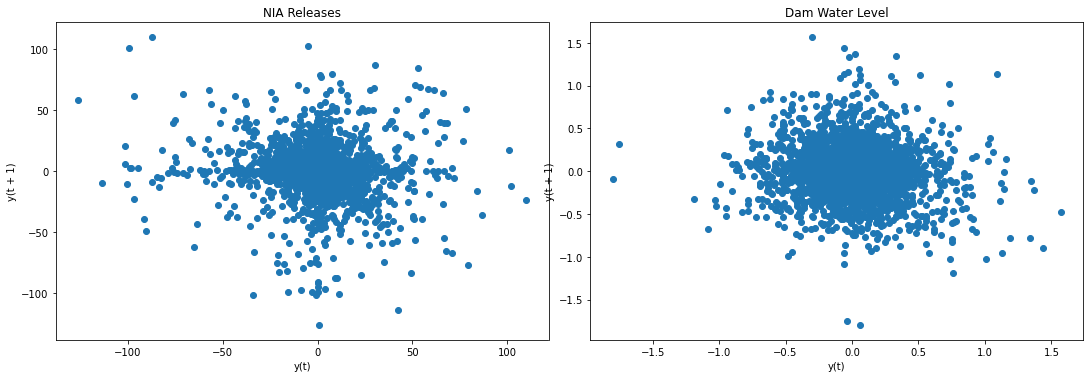

In [9]:
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

# lag_plot(data['Rain'], ax=ax4)
# ax4.set_title('Rainfall');

lag_plot(data['NIA'], ax=ax4)
ax4.set_title('NIA Releases');

lag_plot(data['Dam'], ax=ax5)
ax5.set_title('Dam Water Level');

plt.show()

**Result**: Lag plots confirm results of ADF test and KPSS test.

**Step 2**: Set up a VAR model for the data (without differencing).

In [10]:
model = VAR(train)
model_fitted = model.fit(2)

/Users/eloiventura/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


**Step 4**: Make sure that the VAR is well-specified. For example, ensure that there is no serial correlation in the residuals. If need be, increase p until any autocorrelation issues are resolved.

In [11]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
#The value of this statistic can vary between 0 and 4. 
#The closer it is to the value 2, then there is no significant serial correlation. 
#The closer to 0, there is a positive serial correlation, 
#and the closer it is to 4 implies negative serial correlation.

out = durbin_watson(model_fitted.resid)

for col, val in zip(data.columns, out):
    print(col, ':', round(val, 2))

NIA : 2.02
Dam : 2.06


**Result**: There is no significant correlation between in the residuals.

**Step 5**: Now take the preferred VAR model and add in m additional lags of each of the variables into each of the equations.

In [12]:
model = VAR(train)
model_fitted = model.fit(2)
#get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

2


/Users/eloiventura/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


**Step 6**: Test for Granger non-causality.

In [13]:
maxlag = lag_order
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

o = grangers_causation_matrix(train, variables = train.columns)  

In [14]:
o

,NIA_x,Dam_x
NIA_y,1.0000,0.0007
Dam_y,0.0216,1.0000


**Result**: If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

For this particular example, we can say that NIA releases causes changes in the dam water level. On the other hand, dam water level also causes changes in the NIA releases. This is an example of the feedback mentioned above.

We do the similar steps for the La Mesa dataset.

In [15]:
data = pd.read_csv('../data/La Mesa_dataset.csv', index_col='Time');
data = data.dropna()
data = data.drop(['Rain', 'ONI'], axis=1)
# data['Rain'] = data['Rain'] - data['Rain'].shift(1)
data['NIA'] = data['NIA'] - data['NIA'].shift(1)
data['Dam'] = data['Dam'] - data['Dam'].shift(1)
data = data.dropna()

train = data[:end]
test = data[end:]

model = VAR(train)
model_fitted = model.fit(2)
lag_order = model_fitted.k_ar

maxlag = lag_order
test = 'ssr_chi2test'

o1 = grangers_causation_matrix(train, variables = train.columns)
o1

/Users/eloiventura/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


,NIA_x,Dam_x
NIA_y,1.000,0.1632
Dam_y,0.636,1.0000


We see that, unlike for Ipo, NIA releases and dam water level are NOT causal to one another.

## Exercises

As exercises, the reader can check for causality between other pairs of variables from both the Ipo and La Mesa datasets, as well as from the Angat dataset.

Causality will be revisited in a later chapter, in particular addressing the limitations of the method discussed in this chapter.